In [43]:
import csv
import pandas as pd
import os
import numpy as np
from scipy.signal import savgol_filter
from sklearn.ensemble import IsolationForest

In [44]:
# Read the file directly from GitHub repository (use raw URL and forward slashes)
url = "https://raw.githubusercontent.com/Negarhtf/Neospectra_Soil/main/SE_AI4SH_2024.csv"
csv_file_path = url
df_spectra_data = pd.read_csv(url)
print(df_spectra_data.head())  # Display the first few rows of the dataframe to verify loading

          Sample Name            Device Id          Created At (UTC)  \
0          60_20-50_2  NeoScanner_23040128  2024-11-07T10:48:30.000Z   
1          60_20-50_1  NeoScanner_23040128  2024-11-07T10:48:15.000Z   
2            60_20-50  NeoScanner_23040128  2024-11-07T10:48:00.000Z   
3  005-organic_0-20_2  NeoScanner_23040128  2024-11-07T10:41:36.000Z   
4  005-organic_0-20_1  NeoScanner_23040128  2024-11-07T10:41:21.000Z   

                      Created By  2549.999982  2541.176458  2532.413785  \
0  robert.minarik@opengeohub.org    37.797867    38.070241    38.315491   
1  robert.minarik@opengeohub.org    39.330422    39.616743    39.871226   
2  robert.minarik@opengeohub.org    40.900735    41.148264    41.370901   
3  robert.minarik@opengeohub.org    31.914594    31.926366    31.949304   
4  robert.minarik@opengeohub.org    30.888304    30.902142    30.925548   

   2523.711336  2515.068494  2506.484647  ...  1372.710602  1370.149576  \
0    38.522836    38.699997    38.871561 

In [45]:
# Load CSV file for spectra data
##csv_file_path = "C:/Users/hsfa0259/Desktop/Neospectra/SE_AI4SH_2024_DS.csv"  # location to the site data
#df_site_data = pd.read_csv(csv_file_path, index_col=0) # assuming the first column is index column

In [46]:
# Extract the base name by removing '_1' or '_2' (or any number) from the end
# BUT keep the original name if there's no suffix
df_spectra_data["Sample Name"] = df_spectra_data["Sample Name"].str.replace(r'(_\d+)$', '', regex=True)

# Group by the base name and calculate mean for all numeric columns
mean_df = df_spectra_data.groupby("Sample Name", as_index=False).mean(numeric_only=True)

# Save the results
mean_df.to_excel("mean_values.xlsx", index=False)

print(mean_df.head())  # Display the first few rows of the mean dataframe to verify


        Sample Name  2549.999982  2541.176458  2532.413785  2523.711336  \
0     001-sand_0-20    51.111271    51.231719    51.335209    51.409257   
1    001-sand_20-50    44.497667    44.658945    44.816686    44.984087   
2     002-sand_0-20    35.295046    35.464082    35.605984    35.710701   
3    002-sand_20-50    43.860983    44.188004    44.515867    44.812179   
4  003-organic_0-20    38.327573    38.350856    38.385045    38.418049   

   2515.068494  2506.484647  2497.959193  2489.491539  2481.081099  ...  \
0    51.459450    51.510129    51.594505    51.736268    51.944136  ...   
1    45.172003    45.388175    45.633077    45.902621    46.192581  ...   
2    35.787113    35.862196    35.970076    36.133601    36.359939  ...   
3    45.060214    45.269616    45.475655    45.714678    46.008114  ...   
4    38.451516    38.505020    38.607205    38.779468    39.029761  ...   

   1372.710602  1370.149576  1367.598087  1365.056084  1362.523513  \
0    46.001119    45.858416 

Preprocessing

In [47]:
# === Step 1: Filtering using Savitzky-Golay ===
def apply_savitzky_golay(df, window_length=5, polyorder=2, mode='nearest'):
    """
    Apply Savitzky-Golay filter to smooth spectral data.
    
    :param df: DataFrame containing spectral data (wavelengths as columns)
    :param window_length: Window size for the filter (must be odd)
    :param polyorder: Polynomial order for smoothing
    :return: Smoothed DataFrame
    """
     # Ensure window_length is valid
    if df.shape[0] < window_length:
        raise ValueError(f"window_length ({window_length}) cannot be greater than the number of rows ({df.shape[0]})")

    # Apply Savitzky-Golay filter row-wise
    filtered_array = np.apply_along_axis(
        lambda row: savgol_filter(row, window_length, polyorder, mode="nearest"),
        axis=1,
        arr=df
    )

    # Convert back to DataFrame
    return pd.DataFrame(filtered_array, columns=df.columns, index=df.index)

# === Step 2: Scatter Correction using Standard Normal Variate (SNV) ===
def snv(input_data):
    """
    Applies Standard Normal Variate (SNV) to each row in the dataset.

    Parameters:
    - input_data (pd.DataFrame or np.ndarray): Spectral data.

    Returns:
    - pd.DataFrame: SNV-transformed data with the same shape as input.
    """

    # Ensure input is a NumPy array
    if isinstance(input_data, pd.DataFrame):
        input_array = input_data.to_numpy()
    else:
        input_array = input_data

    # Check for non-numeric data
    if not np.issubdtype(input_array.dtype, np.number):
        raise ValueError("SNV function received non-numeric data.")

    # Compute SNV (normalize each row)
    mean = np.mean(input_array, axis=1, keepdims=True)
    std_dev = np.std(input_array, axis=1, keepdims=True)
    snv_array = (input_array - mean) / std_dev

    # Convert back to DataFrame if original was a DataFrame
    if isinstance(input_data, pd.DataFrame):
        return pd.DataFrame(snv_array, columns=input_data.columns, index=input_data.index)
    return snv_array


# === Step 3: Compute First Derivatives ===
def compute_first_derivative(df):
    """
    Compute the first derivative of spectral data.
    
    :param df: DataFrame containing spectral data
    :return: First derivative DataFrame
    """
    if isinstance(df, np.ndarray):  # Convert to DataFrame if it became an array
        df = pd.DataFrame(df)

    # Get the derivatives
    derivative = df.diff(axis=1, periods=1)

    # Drop first column since diff creates NaN
    derivative.drop(axis=1, columns=derivative.columns[0], inplace=True)

    return derivative

# === Step 4: Remove Outliers using Isolation Forest ===
def remove_outliers(df, contamination=0.1):
    """
    Remove outliers using Isolation Forest.
    
    :param df: DataFrame containing spectral data
    :param contamination: Proportion of data expected to be outliers
    :return: Cleaned DataFrame
    """
    model = IsolationForest(contamination=contamination, random_state=42)
    labels = model.fit_predict(df)
    return df[labels == 1]  # Keep only inliers

In [48]:
# Separate sample names and spectral data
sample_names = mean_df.iloc[:, 0]               # First column = Sample Name
spectral_df = mean_df.iloc[:, 1:]               # All other columns = Wavelengths

# Step 1: Savitzky-Golay filter
spectral_df = apply_savitzky_golay(spectral_df, window_length=5, polyorder=2, mode='nearest')

# Step 2: SNV correction
spectral_df = snv(spectral_df)

# Step 3: First derivative
spectral_df = compute_first_derivative(spectral_df)

# Step 4: Remove outliers
spectral_df = remove_outliers(spectral_df, contamination=0.1)

# Reattach sample names to processed data
processed_df = pd.concat([sample_names.loc[spectral_df.index].reset_index(drop=True),
                          spectral_df.reset_index(drop=True)], axis=1)

# Optional: Save the result
processed_df.to_excel("processed_mean_df.xlsx", index=False)

print(processed_df.head())  # Display the first few rows of the processed dataframe to verify

        Sample Name  2541.176458  2532.413785  2523.711336  2515.068494  \
0     001-sand_0-20     0.017838     0.022929     0.015060     0.010389   
1    001-sand_20-50     0.025015     0.036695     0.035481     0.039888   
2     002-sand_0-20     0.031550     0.040476     0.027148     0.020040   
3    002-sand_20-50     0.051779     0.074073     0.062214     0.052253   
4  003-organic_0-20     0.005019     0.008207     0.008110     0.008503   

   2506.484647  2497.959193  2489.491539  2481.081099  2472.727295  ...  \
0     0.010636     0.017269     0.028870     0.042216     0.054161  ...   
1     0.045750     0.051806     0.057082     0.061401     0.065125  ...   
2     0.019861     0.028047     0.042364     0.058502     0.072520  ...   
3     0.044546     0.043683     0.050442     0.061738     0.073264  ...   
4     0.013639     0.025517     0.042862     0.062088     0.079212  ...   

   1372.710602  1370.149576  1367.598087  1365.056084  1362.523513  \
0    -0.032425    -0.028916 

Data Visualization

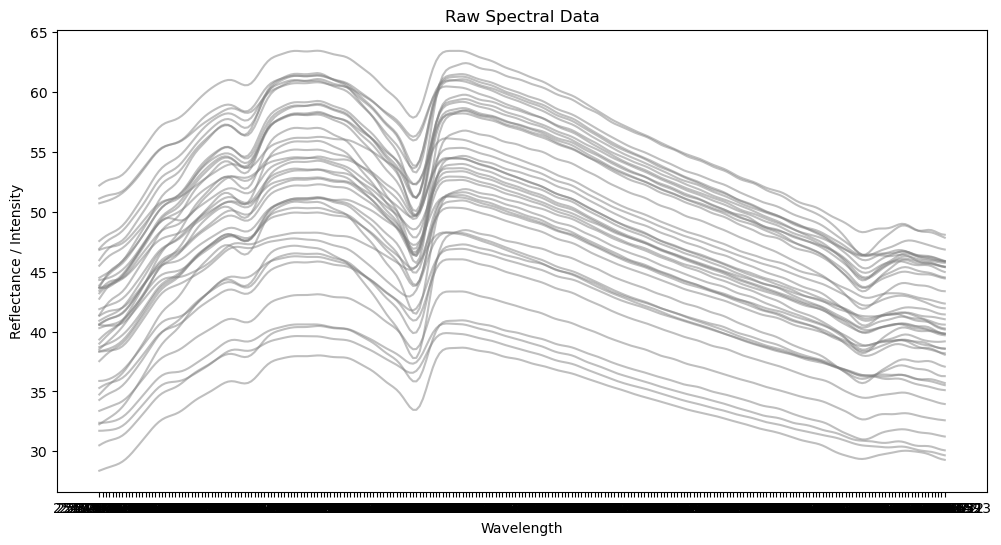

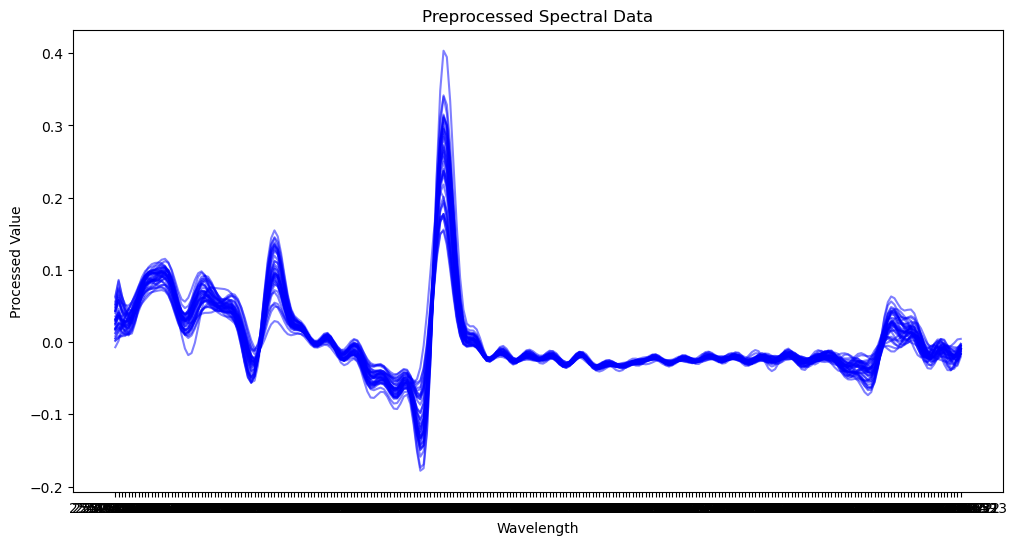

In [49]:
import matplotlib.pyplot as plt

# Plot the raw data
plt.figure(figsize=(12, 6))
for i in range(mean_df.shape[0]):
    plt.plot(mean_df.columns[1:], mean_df.iloc[i, 1:], color='gray', alpha=0.5)
plt.title("Raw Spectral Data")
plt.xlabel("Wavelength")
plt.ylabel("Reflectance / Intensity")
plt.show()

# Plot the processed data (excluding sample names)
plt.figure(figsize=(12, 6))
for i in range(processed_df.shape[0]):
    plt.plot(processed_df.columns[1:], processed_df.iloc[i, 1:], color='blue', alpha=0.5)
plt.title("Preprocessed Spectral Data")
plt.xlabel("Wavelength")
plt.ylabel("Processed Value")
plt.show()


Load soil property data

1. check the type of each column (float, int, string, etc.) -> to check if the data is numerical of object
2. check the missing values (NaN, None, etc.)
3. check the histogram of each properties #datawrangler
4. check the summary statistics of each properties
5. check the correlation statistics of the data

In [53]:
url = "https://raw.githubusercontent.com/Juuuuuuupiter/Neospectra_Soil/main/SE_Wetlab_Neospectra.csv"
csv_file_path = url
df_wetlab_data = pd.read_csv(url)
print(df_wetlab_data.head())  # Display the first few rows of the dataframe to verify loading

##convert data from string to numeric
##df_wetlab_data['pH_water'] = pd.to_numeric(df_wetlab_data['pH_water'], errors='coerce')


         Sample_Name pH(water)  Electrical_conductivity(ÂµS/cm)  \
0           60_20-50       6.5                               26   
1   005-organic_0-20       7.8                              117   
2  003-organic_20-50       7.9                              143   
3  004-organic_20-50       7.8                               99   
4   003-organic_0-20       7.7                              130   

   Total_organic_carbon(%)  Total_nitrogen(%)  Ca2+(cmol+/kg)  Mg2+(cmol+/kg)  \
0                    0.548               0.07            12.6             0.6   
1                    5.610               0.48            50.7             0.7   
2                    6.660               0.48            63.0             1.1   
3                    0.821               0.08            15.3             0.4   
4                    8.920               0.69            82.0             1.5   

   K+(cmol+/kg)  Na+(cmol+/kg)  Cation_exchange_capacity(cmol+/kg)  \
0          0.30          0.025          

In [59]:
#Statistical results of mean, SD, varance, min, max

import pandas as pd
import seaborn as sns

#mean_EC = df_wetlab_data['Electrical conductivity(ÂµS/cm)'].mean()
#print("Mean_EC:", mean_EC)

cols_to_cal = ["pH(water)","Electrical_conductivity(ÂµS/cm)","Total_organic_carbon(%)","Total_nitrogen(%)","Ca2+(cmol+/kg)","Mg2+(cmol+/kg)","K+(cmol+/kg)","Na+(cmol+/kg)","Cation_exchange_capacity(cmol+/kg)","Olsen_Phosphorus(mg/100g)","Clay(<0.002 mm)","Fine_silt(0.002-0.02 mm)","Coarse_silt(0.02-0.06 mm)","Fine_sand(0.06-0.2 mm)","Coarse_sand(0.2 - 2.0 mm)"]
numeric_data = df_wetlab_data[cols_to_cal].apply(pd.to_numeric, errors='coerce')

stats = pd.DataFrame({
    "Mean": numeric_data.mean(),
    "Std Dev": numeric_data.std(),
    "Variance": numeric_data.var(),
    "Min": numeric_data.min(),
    "Max": numeric_data.max(),
    "Range": numeric_data.max() - numeric_data.min()
})

print(stats)




                                         Mean    Std Dev     Variance     Min  \
pH(water)                            6.750000   0.802467     0.643953   5.300   
Electrical_conductivity(ÂµS/cm)     59.800000  33.933491  1151.481818  26.000   
Total_organic_carbon(%)              1.841933   1.961521     3.847566   0.373   
Total_nitrogen(%)                    0.166444   0.146321     0.021410   0.050   
Ca2+(cmol+/kg)                      18.737778  17.657889   311.801040   5.100   
Mg2+(cmol+/kg)                       0.622222   0.258394     0.066768   0.300   
K+(cmol+/kg)                         0.282222   0.226173     0.051154   0.050   
Na+(cmol+/kg)                        0.101111   0.068870     0.004743   0.025   
Cation_exchange_capacity(cmol+/kg)  20.955556   8.237816    67.861616   5.000   
Olsen_Phosphorus(mg/100g)            1.862222   1.273201     1.621040   0.500   
Clay(<0.002 mm)                     18.444444   4.956885    24.570707  10.000   
Fine_silt(0.002-0.02 mm)    

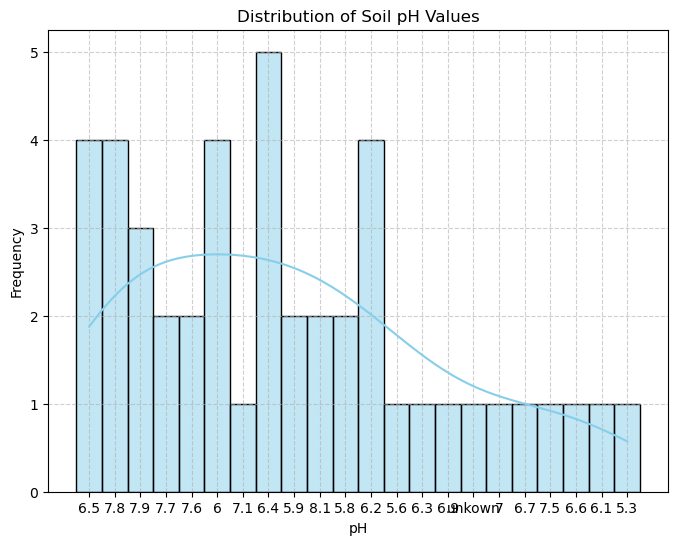

In [ ]:
#frequency graphic of wetlab properties
plt.figure(figsize=(8, 6))
sns.histplot(df_wetlab_data['pH(water)'], bins=20, kde=True, color='skyblue')

plt.title("Distribution of Soil pH Values")
plt.xlabel("pH")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
##manually change the csv file

Model
#PLSR
#Cubist
#RF
